In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install keras scikit-learn imbalanced-learn

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18060487030453109289, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8097278400738675265
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18036798206217171586
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18146341926842565919
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=35, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

number of examples: 2053
dimensionality of images: (154, 154, 3)
number of unique classes (people): 24


[[[35. 28. 20.]
  [35. 28. 20.]
  [34. 27. 19.]
  ...
  [28. 28. 18.]
  [29. 29. 19.]
  [29. 29. 19.]]

 [[35. 28. 20.]
  [35. 28. 20.]
  [35. 28. 20.]
  ...
  [30. 30. 20.]
  [30. 30. 20.]
  [30. 30. 20.]]

 [[36. 29. 21.]
  [36. 29. 21.]
  [36. 29. 19.]
  ...
  [31. 31. 21.]
  [31. 31. 21.]
  [31. 31. 21.]]

 ...

 [[87. 65. 42.]
  [76. 54. 31.]
  [62. 42. 18.]
  ...
  [72. 51. 34.]
  [65. 44. 27.]
  [63. 40. 22.]]

 [[86. 64. 43.]
  [74. 52. 31.]
  [61. 40. 19.]
  ...
  [73. 52. 33.]
  [66. 45. 26.]
  [63. 41. 20.]]

 [[83. 62. 45.]
  [72. 51. 32.]
  [61. 40. 21.]
  ...
  [76. 55. 36.]
  [68. 47. 28.]
  [63. 41. 20.]]]


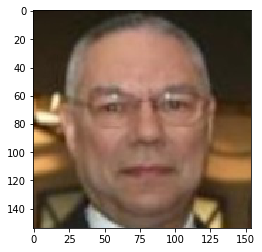

In [6]:
print(lfw_people.images[0])
plt.imshow(lfw_people.images[0].astype(np.uint8))

Gerhard Schroeder


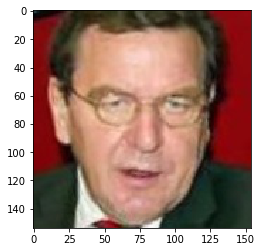

In [7]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i].astype(np.uint8))
plt.grid(False)
print(target_names[y[i]])

In [0]:
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation
from keras import Model

In [9]:
print(lfw_people.images[0].shape)

(154, 154, 3)


In [10]:
input = Input(shape=X.shape[1:])                                  # 154x154x3
x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  # 154x154x12
x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      # 77x77x12
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      # 77x77x16
x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      # 38x38x16
x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      # 38x38x24
x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      # 19x19x24
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)      # 19x19x32
x = Conv2D(32, (2, 2), strides=(2, 2), activation='relu')(x)      # 9x9x32
x = Conv2D(48, (3, 3), padding='same', activation='relu')(x)      # 9x9x48
x = Conv2D(48, (2, 2), strides=(2, 2), activation='relu')(x)      # 4x4x48
x = Dropout(0.5)(x)                                               # 4x4x48
x = Conv2D(n_classes, (1, 1))(x)                                  # 4x4x62
x = GlobalAvgPool2D()(x)                                          # 62
output = Activation('softmax')(x)      

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

In [0]:
batch_size = 256
test_split = 0.2
base_lr = 0.001
epochs = 100

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=42)

# oversampling each class to contain at least 256 examples
sampling_targets = np.maximum([256] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

# one-hot encoding of labels
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# compile model and define optimization
model = Model(inputs=input, outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(lr=base_lr),
              metrics=['accuracy'])


In [0]:
# model training 🎉
# history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
#                     steps_per_epoch=len(X_train) / batch_size,
#                     epochs=100,
#                     verbose=1,
#                     validation_data=(X_test, y_test))

In [0]:
model.load_weights('weights100epochs.h5')

In [0]:
#model.save_weights('weights100epochs.h5')
#model.save('100epochs.h5')

In [16]:
original_image = np.expand_dims(X_test[22], axis=0)
predictions = model.predict(original_image)

#Function to output the predictions with class labels and confidence percentage
def decode_predictions(pred, first_x):
  temp_list = pred.tolist()
  temp_list = temp_list[0] #Since predictions gives a 2D numpy array
  for x in range(0, first_x):
    i = temp_list.index(max(temp_list))
    print(x+1,'-->', target_names[i], "with confidence of", temp_list[i]*100, '%')
    temp_list.remove(temp_list[i])
    
#Function to output class label from a given y_test or y_train array
def y2class(y_label):
  temp_list = y_label.tolist()
  ind = temp_list.index(max(temp_list))
  print(target_names[ind], ind)

#y_test2target_name(y_test[4])    
decode_predictions(predictions, 3)

1 --> Gerhard Schroeder with confidence of 64.20437097549438 %
2 --> Alvaro Uribe with confidence of 20.50492763519287 %
3 --> Gloria Macapagal Arroyo with confidence of 12.87609338760376 %


In [17]:
# print(y_test[4])
test_img = np.expand_dims(X_test[22], axis=0)
decode_predictions(model.predict(test_img), 3)

1 --> Gerhard Schroeder with confidence of 64.20437097549438 %
2 --> Alvaro Uribe with confidence of 20.50492763519287 %
3 --> Gloria Macapagal Arroyo with confidence of 12.87609338760376 %


Hugo Chavez 11
(154, 154, 3)


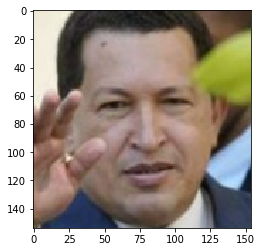

In [18]:
from PIL import Image

y2class(y_test[22])
plot_img = X_test[22]
plot_img = plot_img.reshape((154,154,3))
plot_img = plot_img.astype(np.uint8)
print(plot_img.shape)
plt.imshow(plot_img)
plt.show()


# Saving the original image X_test[0]
im = Image.fromarray(plot_img)
im.save("image_original.png")

# Downloading image
from google.colab import files
files.download("image_original.png" ) 

https://colab.research.google.com/drive/1xSIiv8iQDEsdSgjuLE6vOhxFpG-xQC0Q

Link to main CNN file


---

# Hacking Image

In [19]:
!pip install foolbox

In [20]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.attacks import DeepFoolAttack, BIM, GradientAttack, LBFGSAttack, SaliencyMapAttack
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
#from keras.applications.resnet50 import decode_predictions

#keras.backend.set_learning_phase(0)
#kmodel = ResNet50(weights='imagenet')
#fmodel = KerasModel(model, bounds=(0, 255), preprocessing=preprocessing)

#preprocessing = (np.array([104, 116, 123]), 1)

fmodel = KerasModel(model, bounds=(0, 255)) #ADD , preprocessing=preprocessing

# image, label = foolbox.utils.imagenet_example()

# # run the attack
# attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(781, p=.5))
# adversarial = attack(image[:, :, ::-1], label)

# # show results
# print(np.argmax(fmodel.predictions(adversarial)))
# print(foolbox.utils.softmax(fmodel.predictions(adversarial))[781])
# adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
# preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
# print("Top 5 predictions (adversarial: ", decode_predictions(preds, top=5))

Instructions for updating:
Use tf.cast instead.


## We want to hack this image

Hugo Chavez 11
(154, 154, 3)


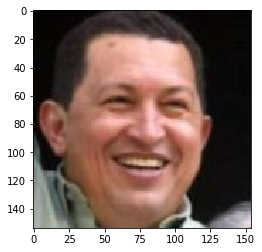

In [48]:
y2class(y_train[12])
plot_img = X_train[12].reshape((154,154,3))
plot_img = plot_img.astype(np.uint8)
print(plot_img.shape)
plt.imshow(plot_img)
plt.show()

In [22]:
test_img = np.expand_dims(X_test[28], axis=0)
decode_predictions(model.predict(test_img), 3)

1 --> Donald Rumsfeld with confidence of 99.97188448905945 %
2 --> Colin Powell with confidence of 0.026795556186698377 %
3 --> Nestor Kirchner with confidence of 0.0005962830528005725 %


## Running the attack using Foolbox

In [44]:
image = X_train[12] #Do not put test_img since it has been expanded
label = 11

# run the attack
# attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(3, p=.99))
# attack = BIM(model=fmodel, criterion=TargetClassProbability(3, p=.99))
attack = SaliencyMapAttack(model=fmodel, criterion=TargetClassProbability(3, p=.99))

# attack = DeepFoolAttack(model=fmodel, criterion=TargetClassProbability(1, p=.2))

adversarial = attack(image[:, :, :], label) #image[:, :, ::-1] For BGR

# show results
print(np.argmax(fmodel.predictions(adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[2])
adversarial_rgb = adversarial[np.newaxis, :, :, :] #image[:, :, ::-1] For BGR
preds = model.predict(adversarial_rgb)

print("Prediction: ", preds)

3
0.00016231021
Prediction:  [[2.1462936e-05 1.5336843e-06 1.6231023e-04 9.9000496e-01 1.4183631e-07
  7.3449039e-03 1.6517123e-06 9.9721012e-07 1.5029440e-05 8.2247325e-06
  9.1300670e-08 5.5204821e-04 3.0009789e-04 1.5812155e-03 4.9384052e-08
  2.4422878e-08 1.2555267e-11 2.2454638e-09 3.4997918e-11 1.3155819e-08
  3.2473886e-06 6.4731591e-07 1.3741919e-06 8.2035186e-08]]


(1, 154, 154, 3)
1 --> Ariel Sharon with confidence of 99.00049567222595 %


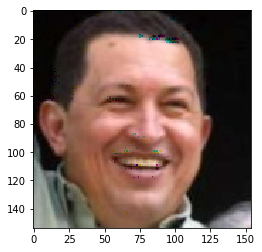

<Figure size 432x288 with 0 Axes>

In [45]:
from PIL import Image

print(adversarial_rgb.shape)
adv_img = adversarial_rgb
if(adv_img.shape == (154, 154, 3)):
  adv_img = np.expand_dims(adv_img, axis=0)
decode_predictions(model.predict(adv_img),1)

#decode_predictions(model.predict(adv_img,1))
adv_img = adv_img.reshape((154, 154, 3))
adv_img = adv_img.astype(np.uint8)
plt.imshow(adv_img)
plt.show()
plt.figure()

im = Image.fromarray(adv_img)
im.save("adv_img.png")

from google.colab import files
files.download( "adv_img.png" )

Original
Hugo Chavez 11


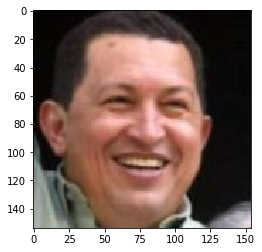

In [46]:
print("Original")

y2class(y_train[12])
og_img = X_train[12]
og_img = og_img.reshape((154,154,3))
og_img = og_img.astype(np.uint8)
plt.imshow(og_img)
plt.show()

im = Image.fromarray(adv_img)
im.save("og_img.png")

from google.colab import files
files.download( "og_img.png" )



# print("Adversarial")
# if(adv_img.shape == (154, 154, 3)):
#   adv_img = np.expand_dims(adv_img, axis=0)
# decode_predictions(model.predict(adv_img),1)
# adv_img = adversarial_rgb.reshape((154, 154, 3))
# adv_img = adv_img.astype(np.uint8)
# plt.imshow(adv_img)
# plt.show()
# plt.figure()



In [47]:
ch = X_train[12]
ch = np.expand_dims(ch, axis = 0)
decode_predictions(model.predict(ch), 3)

1 --> Hugo Chavez with confidence of 99.79380965232849 %
2 --> Gerhard Schroeder with confidence of 0.20550943445414305 %
3 --> Arnold Schwarzenegger with confidence of 0.0005951119419478346 %
